In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
# %% [markdown]
# # 改进因子3：市场状态自适应自相关因子

# %%
def factor(df):
    """
    改进点：
    1. 动态识别市场状态（趋势/震荡）
    2. 不同市场状态使用不同参数
    3. 引入订单流不平衡指标
    """
    # 计算订单流不平衡
    df['taker_sell_volume'] = df['volume'] - df['taker_buy_volume']
    ofi = (df['taker_buy_volume'] - df['taker_sell_volume']) / df['volume']
    
    # 计算自适应波动率
    ret = df['close'].pct_change()
    short_vol = ret.rolling(96).std()  # 短期波动率（24小时）
    long_vol = ret.rolling(1920).std()  # 长期波动率（20天）
    vol_ratio = short_vol / (long_vol + 1e-8)
    
    # 市场状态分类（波动率比率阈值）
    market_state = pd.Series('Neutral', index=df.index)
    market_state[vol_ratio > 1.2] = 'Trending'
    market_state[vol_ratio < 0.8] = 'MeanReverting'
    
    # 状态自适应参数
    params = {
        'Trending': {'window': 384, 'halflife': 48},  # 短期参数（趋势市场）
        'MeanReverting': {'window': 2880, 'halflife': 192},  # 长期参数（震荡市场）
        'Neutral': {'window': 1920, 'halflife': 96}  # 中性参数
    }
    
    # 量价结合收益率
    vwap = (df['turnover'] / df['volume']).replace([np.inf, -np.inf], np.nan).ffill()
    ret_vwap = np.log(vwap).diff()
    
    # 状态自适应处理
    factor_components = []
    for state in ['Trending', 'MeanReverting', 'Neutral']:
        mask = (market_state == state)
        state_ret = ret_vwap[mask]
        if len(state_ret) < 10:
            continue
        
        p = params[state]
        # 指数加权基准
        benchmark = state_ret.ewm(halflife=p['halflife']).mean().shift(1)
        excess = state_ret - benchmark
        
        # 滚动自相关
        autocorr = excess.rolling(p['window']).corr(excess.shift(1))
        factor_components.append(autocorr)
    
    # 合并因子
    factor = pd.concat(factor_components).sort_index()
    return factor.reindex(df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.000665
   Rank_IC (Spearman): 0.006739
📊 信息比率:
   IR: -0.590133
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127018
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


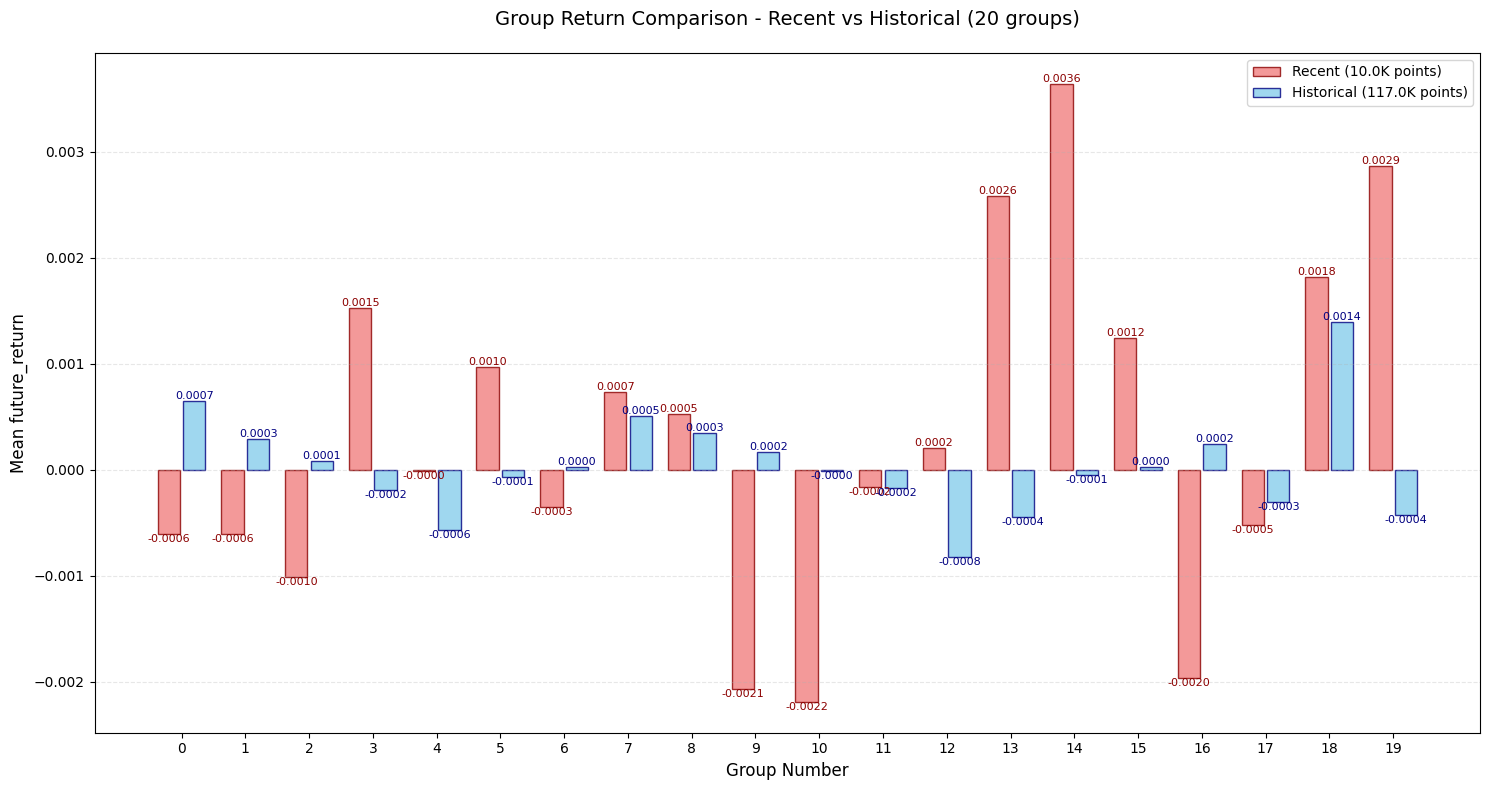

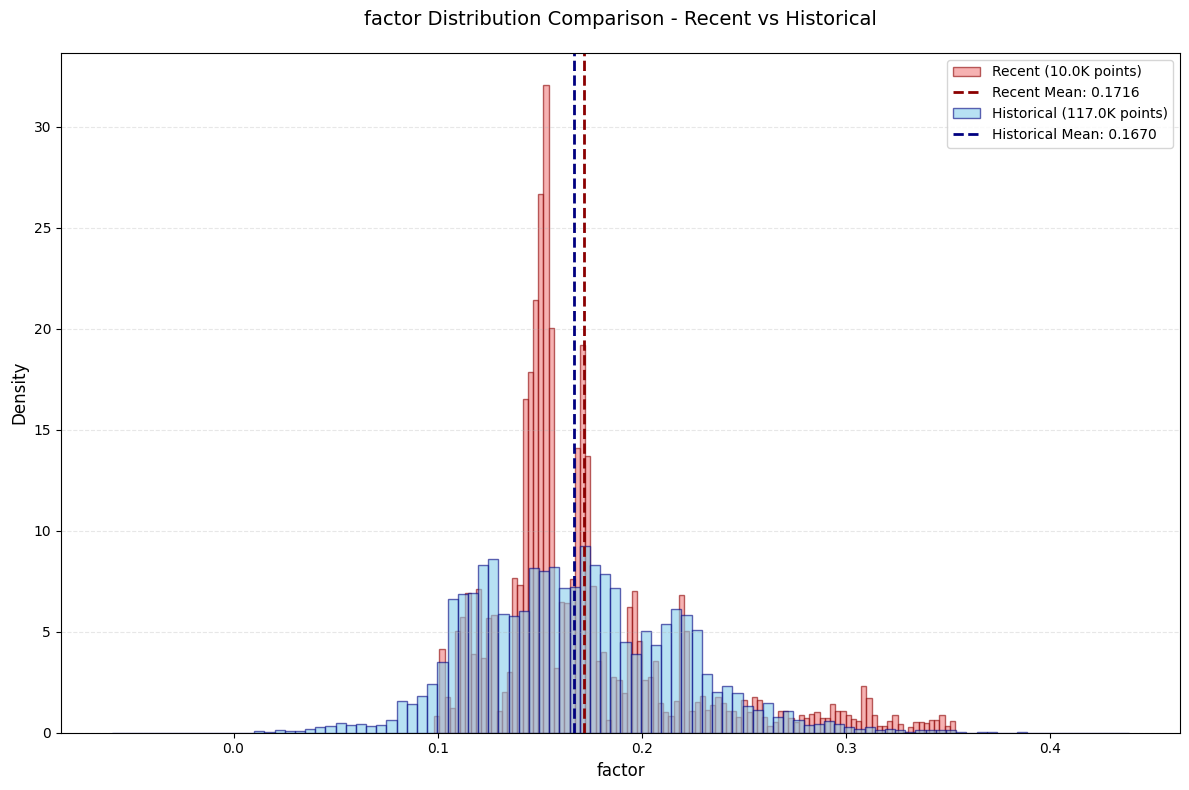

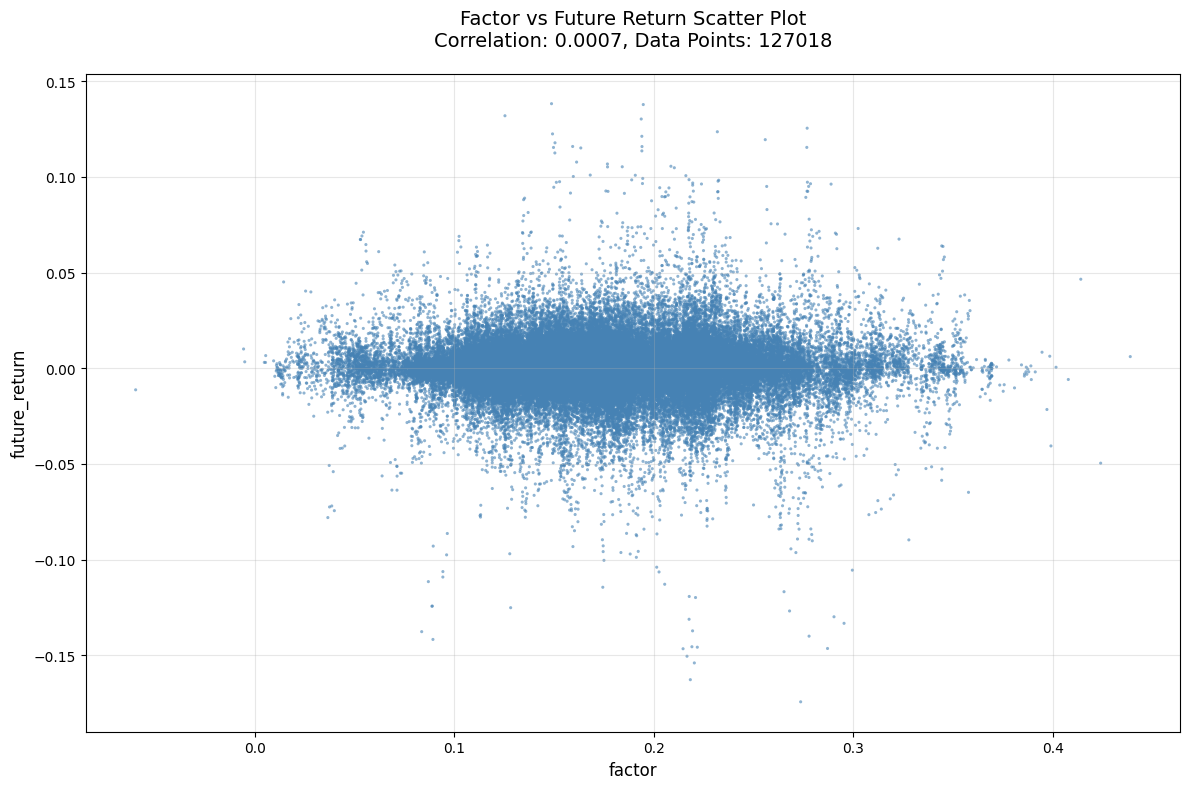

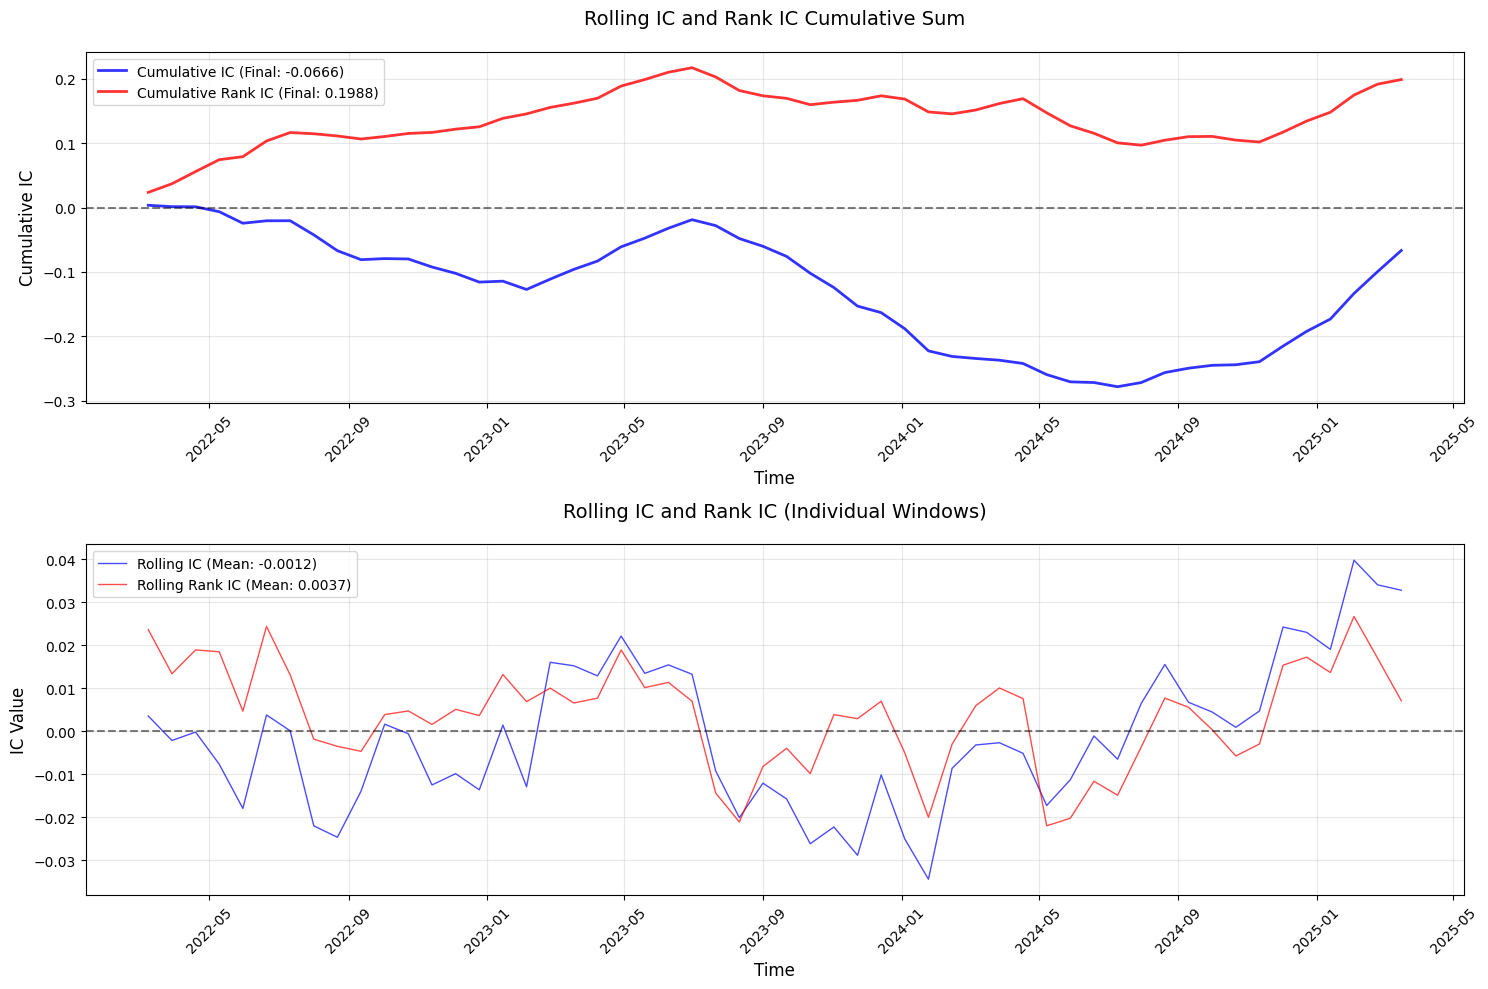

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [6]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+-----------------------+
| 指标                | 值                    |
+=====================+=======================+
| 信息系数(IC)        | 0.0006650555493740548 |
+---------------------+-----------------------+
| 秩相关系数(Rank IC) | 0.006739445669878433  |
+---------------------+-----------------------+
| 信息比率(IR)        | -0.590133242073242    |
+---------------------+-----------------------+
| 分组数量            | 10                    |
+---------------------+-----------------------+
| 数据点数            | 127,018               |
+---------------------+-----------------------+
| 异常值(>3σ)         | 62.92%                |
+---------------------+-----------------------+
| 异常值(>5σ)         | 5.73%                 |
+---------------------+-----------------------+

                                     分组分析结果                                     
+--------+----------+----------+----------+--------